# Pipeline + Training

In [1]:
!pip install bs4
!pip install statsmodels

In [2]:
import warnings
warnings.filterwarnings("ignore")

import bs4 as bs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psbody.mesh
import seaborn as sns
import torch

pd.options.display.max_colwidth = 100

In [3]:
sns.set_context("paper")
sns.set_palette("muted", desat=1)
palette_list = list(sns.color_palette())
sns.color_palette()

[(0.2823529411764707, 0.4705882352941174, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.29019607843137263),
 (0.415686274509804, 0.7999999999999998, 0.3921568627450982),
 (0.8392156862745099, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647058, 0.7058823529411765),
 (0.5490196078431373, 0.38039215686274513, 0.23529411764705888),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.835294117647059, 0.7333333333333333, 0.4039215686274509),
 (0.5098039215686273, 0.7764705882352942, 0.8862745098039216)]

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading Dataset

Currently commented out because I have pickled the training data. Uncomment this when you are running it for the first time.

In [5]:
# from coma.datasets.ukbb_meshdata import UKBBMeshDataset, VerticesDataLoader
# from coma.utils import transforms

# # Preprocessor
# preprocessor = transforms.get_transforms()

# brain_substructure = 'BrStem'

# # Load Dataset
# mesh_path = "/vol/biomedic3/bglocker/brainshapes"
# cache_path = "/vol/bitbucket/rrr2417/deepscm_data_cache"
# csv_path = "/vol/biomedic3/bglocker/brainshapes/ukb21079_extracted.csv"
# split = 0.8

# substructure_to_udi = {
#     'BrStem': '25025-2.0', 
#     'L_Thal': '25011-2.0',
#     'L_Caud': '25013-2.0',
#     'L_Puta': '25015-2.0',
#     'L_Pall': '25017-2.0',
#     'L_Hipp': '25019-2.0',
#     'L_Amyg': '25021-2.0',
#     'L_Accu': '25023-2.0',
#     'R_Thal': '25012-2.0',
#     'R_Caud': '25014-2.0',
#     'R_Puta': '25016-2.0',
#     'R_Pall': '25018-2.0',
#     'R_Hipp': '25020-2.0',
#     'R_Amyg': '25022-2.0',
#     'R_Accu': '25024-2.0',
# }

# feature_name_map = {
#     '31-0.0': 'sex',
#     '21003-0.0': 'age',
#     substructure_to_udi[brain_substructure]: 'structure_volume',  # Brain Stem
#     '25010-2.0': 'brain_volume',  # Unnormalised brain volume from UKBB
# }

# metadata_df = pd.read_csv(csv_path)

# total_train_dataset = UKBBMeshDataset(
#     mesh_path,
#     substructures=[brain_substructure],
#     split=split,
#     train=True,
#     transform=preprocessor,
#     reload_path=True,
#     features_df=metadata_df,
#     feature_name_map=feature_name_map,
#     cache_path=cache_path,
# )

# val_split = 0.1
# total_train_length = len(total_train_dataset)
# val_length = int(val_split * total_train_length)
# train_length = total_train_length - val_length

# train_dataset, val_dataset = torch.utils.data.random_split(
#     total_train_dataset,
#     lengths=[train_length, val_length],
#     generator=torch.Generator().manual_seed(42),
# )

# data = [train_dataset[i] for i in range(len(train_dataset))]
# meshes = torch.cat([mesh for (mesh, _) in data], 0).detach().numpy()
# print(meshes.shape)
# metadata_df = pd.concat([df for (_, df) in data], 0)
# print(metadata_df.shape)
# metadata_df.head()

# torch.save(meshes, 'training_meshes.pt')
# metadata_df.to_csv('training_metadata.csv')

In [6]:
meshes = torch.load('training_meshes.pt')
metadata_df = pd.read_csv('training_metadata.csv')

print(meshes.shape)
metadata_df.head()

(10441, 642, 3)


,Unnamed: 0,eid,sex,age,structure_volume,brain_volume
0,8809,3820915,0,56,23764,1041180
1,11675,3677460,1,66,22000,1143400
2,9633,4383421,1,63,27148,1369520
3,8374,3069151,0,59,20223,980627
4,14213,1457636,0,50,21183,1386220


In [7]:
path = '/vol/biomedic3/bglocker/brainshapes/ukb21079_extracted.csv'
metadata_df_full = pd.read_csv(path)
mask = metadata_df_full.eid.isin(metadata_df.eid.values)
metadata_df_full = metadata_df_full[mask]

## Data Exploration

Features with column names in a strange format. The key for the column names is found in the HTML in the next part. HTML containing key for column names from dataframe above.

In [8]:
source = '/vol/biomedic3/bglocker/brainshapes/ukb21079.html'
soup = bs.BeautifulSoup(source)

In [9]:
with open(source, 'r') as metadata_html:
    metadata_str = ' '.join([row[:-1] for row in metadata_html.readlines()])
    soup = bs.BeautifulSoup(metadata_str)

In [10]:
key_table = soup.body.find_all('table')[1].tbody

headers = [
    header.get_text()
    for header in key_table.tr.find_all('th')
]

tds = []
for x in list(key_table.find_all('tr')):
    td = x.find_all('td')
    if td:
        td = [elem.get_text() for elem in td]
        tds.append(td)

# Remove any null descriptor fields
headers_df = pd.DataFrame(tds, columns=headers)
mask = (headers_df.Type.isnull()) & (headers_df.Description.isnull())
print('Aftering filtering:', headers_df[~mask].shape)
headers_df_clean = headers_df[~mask]

headers_df_clean.head(5)

Aftering filtering: (958, 5)


,Column,UDI,Count,Type,Description
0,0,eid,502616,Sequence,Encoded anonymised participant ID
1,1,21-0.0,500901,Categorical (single),Weight methodUses data-coding 100261 comprises 5 Integer-valued members in a simple list.
4,4,23-0.0,456674,Categorical (single),Spirometry methodUses data-coding 100270 comprises 5 Integer-valued members in a simple list.
7,7,31-0.0,502616,Categorical (single),SexUses data-coding 9 comprises 2 Integer-valued members in a simple list.
8,8,34-0.0,502616,Integer,Year of birth


In [11]:
vol_mask_right = (headers_df_clean.Description.str.contains('right') & \
    headers_df_clean.Description.str.contains('Volume')) | \
    (headers_df_clean.Description == 'Volume of brain, grey+white matter')
vol_mask_right = headers_df_clean[vol_mask_right]
vol_mask_right.head(30)

,Column,UDI,Count,Type,Description
597,597,25010-2.0,14520,Continuous,"Volume of brain, grey+white matter"
599,599,25012-2.0,14503,Continuous,Volume of thalamus (right)
601,601,25014-2.0,14503,Continuous,Volume of caudate (right)
603,603,25016-2.0,14503,Continuous,Volume of putamen (right)
605,605,25018-2.0,14503,Continuous,Volume of pallidum (right)
607,607,25020-2.0,14503,Continuous,Volume of hippocampus (right)
609,609,25022-2.0,14503,Continuous,Volume of amygdala (right)
611,611,25024-2.0,14503,Continuous,Volume of accumbens (right)


In [12]:
vol_mask_left = (headers_df_clean.Description.str.contains('left') & \
    headers_df_clean.Description.str.contains('Volume')) | \
    (headers_df_clean.Description == 'Volume of brain, grey+white matter')
vol_mask_left = headers_df_clean[vol_mask_left]
vol_mask_left.head(30)

,Column,UDI,Count,Type,Description
597,597,25010-2.0,14520,Continuous,"Volume of brain, grey+white matter"
598,598,25011-2.0,14503,Continuous,Volume of thalamus (left)
600,600,25013-2.0,14503,Continuous,Volume of caudate (left)
602,602,25015-2.0,14503,Continuous,Volume of putamen (left)
604,604,25017-2.0,14503,Continuous,Volume of pallidum (left)
606,606,25019-2.0,14503,Continuous,Volume of hippocampus (left)
608,608,25021-2.0,14503,Continuous,Volume of amygdala (left)
610,610,25023-2.0,14503,Continuous,Volume of accumbens (left)


Selecting relevant fields from HTML key document

In [13]:
desc_mask = headers_df_clean.Description.str.contains('brain stem') | \
    headers_df_clean.Description.str.contains('Age when attended assessment centre') | \
    headers_df_clean.Description.str.contains('Sex') | \
    (headers_df_clean.Description == 'Volume of brain, grey+white matter')
headers_df_clean[desc_mask].head(26)

,Column,UDI,Count,Type,Description
7,7,31-0.0,502616,Categorical (single),SexUses data-coding 9 comprises 2 Integer-valued members in a simple list.
510,510,21003-0.0,502616,Integer,Age when attended assessment centre
597,597,25010-2.0,14520,Continuous,"Volume of brain, grey+white matter"
612,612,25025-2.0,14503,Continuous,Volume of brain stem + 4th ventricle


Extracting relevant fields from metadata. We have already selected these field through the dataset in the cells at the top of the notebook.

In [14]:
print(['eid'] + headers_df_clean[desc_mask].UDI.to_list())

['eid', '31-0.0', '21003-0.0', '25010-2.0', '25025-2.0']


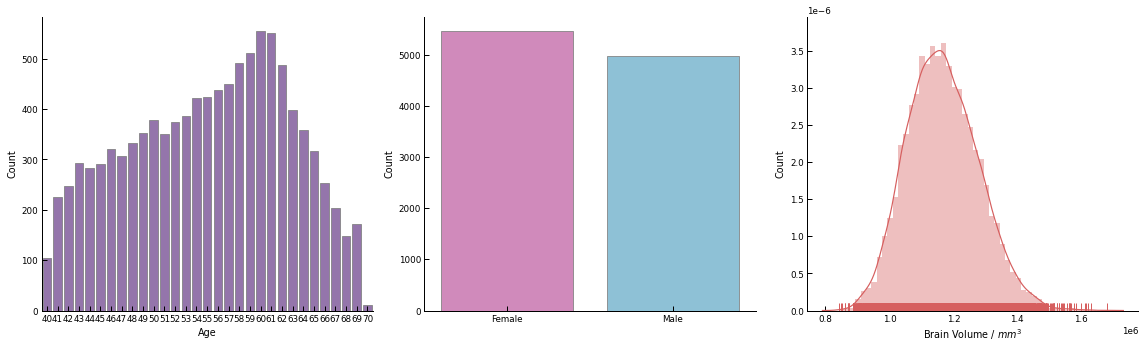

In [17]:
width = 16
height = width / (1.618 * 2)
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(width, height))

age_counts = metadata_df['age'].value_counts().sort_index(ascending=True)
palette = [palette_list[4]] * len(age_counts)
ax = sns.barplot(
    age_counts.index,
    age_counts.values,
    ax=axes[0],
    edgecolor='gray',
    palette=palette
)
ax.set(xlabel='Age', ylabel='Count')
ax.tick_params(axis='y', direction='in')
ax.tick_params(axis='x', direction='in')

palette = [palette_list[6], palette_list[-1]]
gender_counts = metadata_df['sex'].value_counts()
gender_counts.index = ['Female', 'Male']
ax = sns.barplot(
    gender_counts.index,
    gender_counts.values,
    ax=axes[1],
    edgecolor='gray',
    palette=palette
)
ax.tick_params(axis='y', direction='in')
ax.tick_params(axis='x', direction='in')
ax.set(ylabel='Count')

ax = sns.distplot(
    metadata_df['brain_volume'],
    ax=axes[2],
    color=palette_list[3],
    rug=True,
)
ax.tick_params(axis='y', direction='in')
ax.tick_params(axis='x', direction='in')
ax.set(xlabel='Brain Volume / $mm^3$', ylabel='Count')

sns.despine()
fig.tight_layout()
plt.savefig('age_sex_counts.png', dpi=300)

In [25]:
metadata_df_full.isin(metadata_df.eid)

((10441, 6), (10441, 2461))

<Figure size 1152x1152 with 0 Axes>

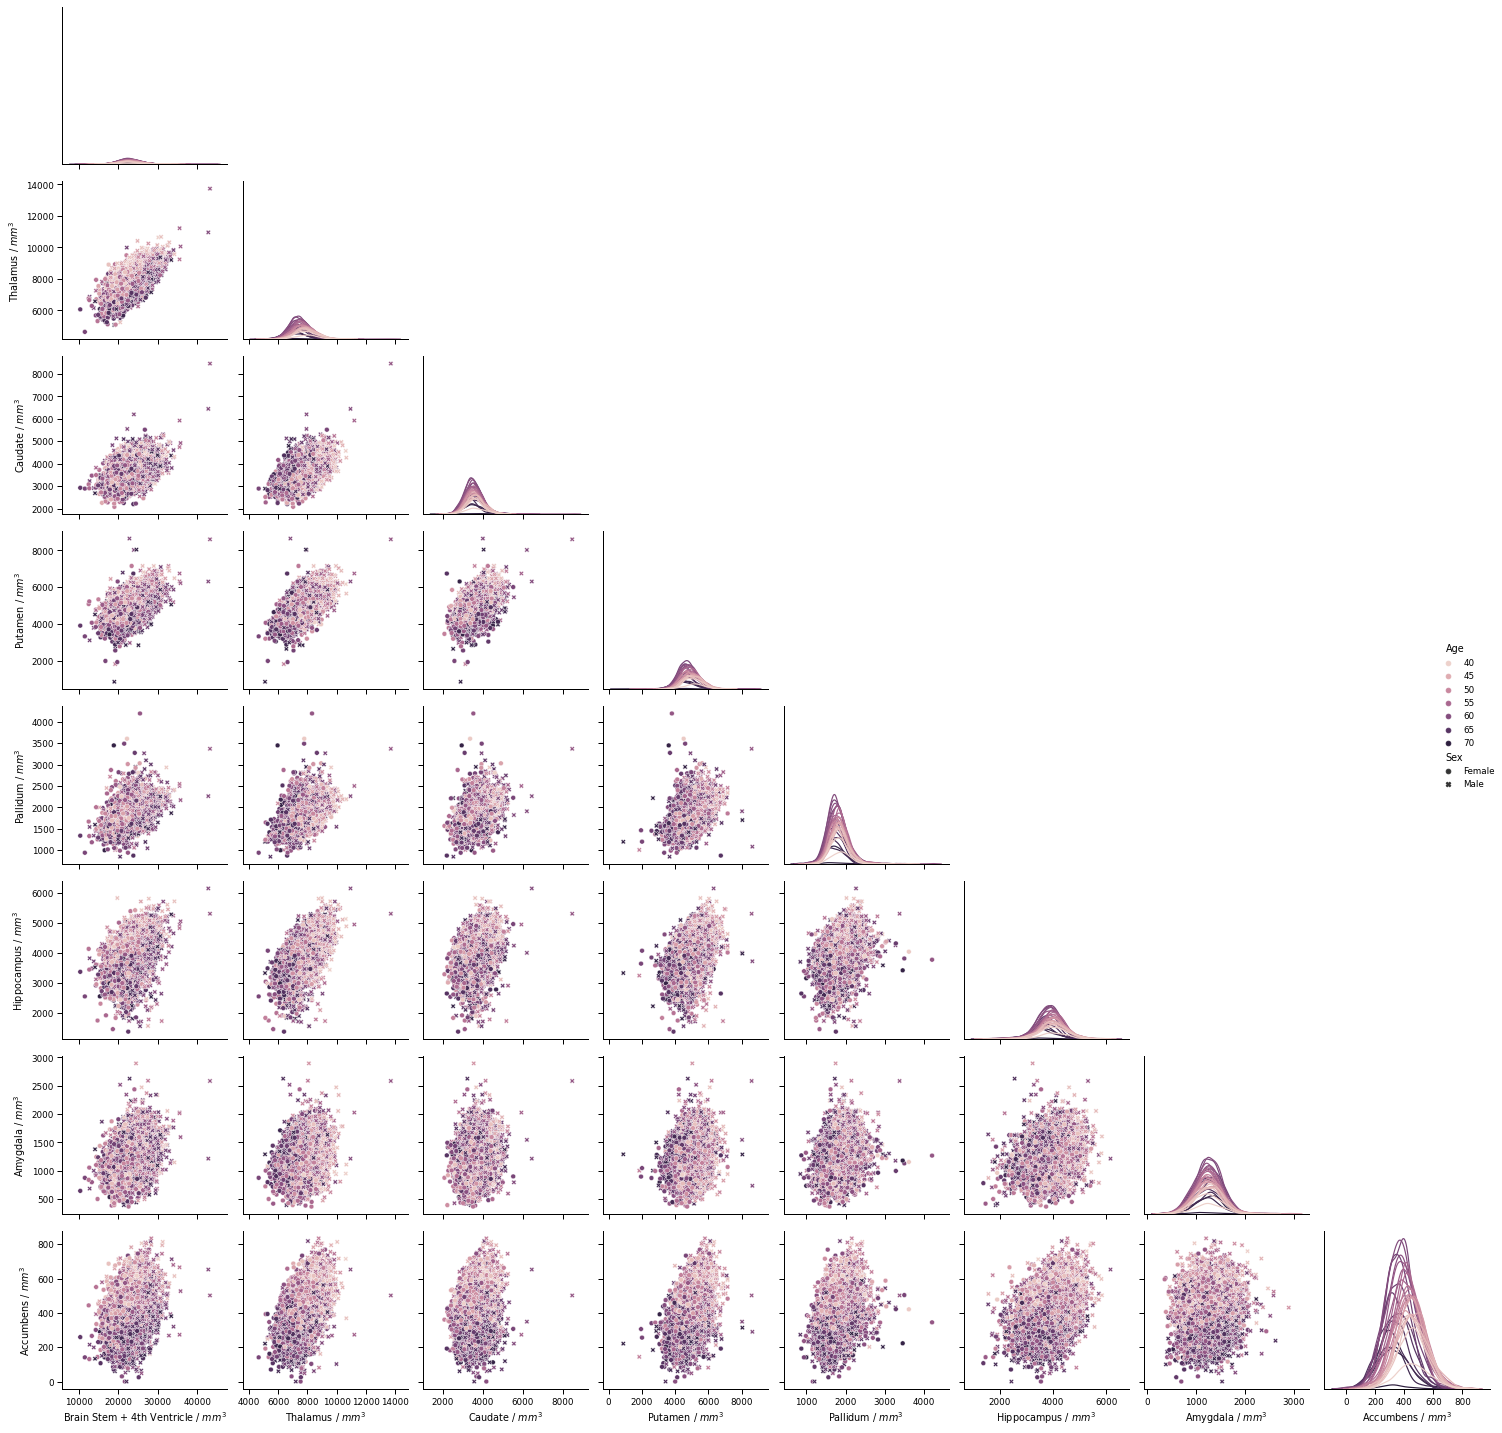

In [80]:
width = 16
height = 16
plt.figure(figsize=(width, height))

rename_cols = {
    '25025-2.0': 'Brain Stem + 4th Ventricle / $mm^3$',
    '25012-2.0': 'Thalamus / $mm^3$',
    '25014-2.0': 'Caudate / $mm^3$',
    '25016-2.0': 'Putamen / $mm^3$',
    '25018-2.0': 'Pallidum / $mm^3$',
    '25020-2.0': 'Hippocampus / $mm^3$',
    '25022-2.0': 'Amygdala / $mm^3$',
    '25024-2.0': 'Accumbens / $mm^3$',
    '21003-0.0': 'Age',
    '31-0.0': 'Sex',
}

vals = list(rename_cols.values())
volumes_df = metadata_df_full[list(rename_cols.keys())]
volumes_df.rename(columns=rename_cols, inplace=True)
volumes_df.replace({'Sex': {0: 'Female', 1: 'Male'}}, inplace=True)

ax = sns.PairGrid(
    volumes_df,
    vars=vals[:-2],
    hue='Age',
    corner=True,
)
ax.map_diag(sns.kdeplot)
ax.map_lower(sns.scatterplot, style=volumes_df['Sex'])
ax.add_legend(title="", adjust_subtitles=True)

sns.despine()
plt.tight_layout()
plt.savefig('subcortial_volume_pairplot.png', dpi=300)
plt.show()

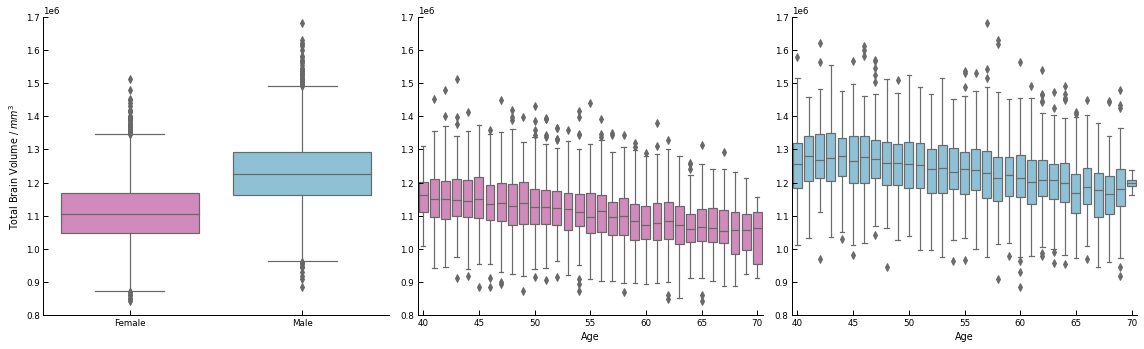

In [81]:
width = 16
height = width / (1.618 * 2)

palette = [palette_list[6], palette_list[-1]]

fig = plt.figure(figsize=(width, height))
y_interval = [0.8e6, 1.7e6]
x_interval = 5

ax1 = plt.subplot2grid((1, 3), (0, 0))
gender_vol = metadata_df[['sex', 'brain_volume']]
ax = sns.boxplot(
    gender_vol.sex,
    gender_vol.brain_volume,
    ax=ax1,
    palette=palette
)
ax.set(
    xlabel=None,
    ylabel='Total Brain Volume / $mm^3$',
    xticklabels=['Female', 'Male']
)
ax.set_ylim(y_interval)
ax.tick_params(axis='y', direction='in')
ax.tick_params(axis='x', direction='in')

ax2 = plt.subplot2grid((1, 3), (0, 1))
sns.boxplot(
    x='age',
    y='brain_volume',
    data=metadata_df[metadata_df['sex'] == 0],
    ax=ax2,
    color=palette[0],
)
ax2.set_ylim(y_interval)
ax2.set_xticks(ax2.get_xticks()[::x_interval])
ax2.set(ylabel=None, xlabel='Age')
ax2.tick_params(axis='y', direction='in')
ax2.tick_params(axis='x', direction='in')

ax3 = plt.subplot2grid((1, 3), (0, 2))
sns.boxplot(
    x='age',
    y='brain_volume',
    data=metadata_df[metadata_df['sex'] == 1],
    ax=ax3,
    color=palette[1],
)
ax3.set_ylim(y_interval)
ax3.set_xticks(ax3.get_xticks()[::x_interval])
ax3.set(ylabel=None, xlabel='Age')
ax3.tick_params(axis='y', direction='in')
ax3.tick_params(axis='x', direction='in')

sns.despine()

fig.tight_layout()
plt.savefig('age_sex_box_plots.png', dpi=300)

<Figure size 1152x355.995 with 0 Axes>

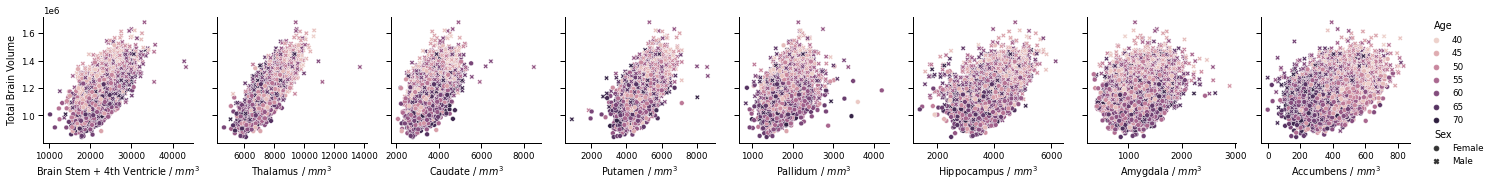

In [82]:
rename_cols = {
    '25025-2.0': 'Brain Stem + 4th Ventricle / $mm^3$',
    '25012-2.0': 'Thalamus / $mm^3$',
    '25014-2.0': 'Caudate / $mm^3$',
    '25016-2.0': 'Putamen / $mm^3$',
    '25018-2.0': 'Pallidum / $mm^3$',
    '25020-2.0': 'Hippocampus / $mm^3$',
    '25022-2.0': 'Amygdala / $mm^3$',
    '25024-2.0': 'Accumbens / $mm^3$',
    '21003-0.0': 'Age',
    '31-0.0': 'Sex',
    '25010-2.0': 'Total Brain Volume',
}

width = 16
height = width / (1.618 * 2)
plt.figure(figsize=(width, height))

vals = list(rename_cols.values())
volumes_df = metadata_df_full[list(rename_cols.keys())]
volumes_df.rename(columns=rename_cols, inplace=True)
volumes_df.replace({'Sex': {0: 'Female', 1: 'Male'}}, inplace=True)

ax = sns.PairGrid(
    volumes_df,
    x_vars=vals[:-3],
    y_vars=vals[-1],
    hue='Age',
)

ax.map_offdiag(sns.scatterplot, style=volumes_df['Sex'])
ax.add_legend(title='', adjust_subtitles=True)

sns.despine()
# plt.tight_layout()
plt.savefig('total_to_subcortial_pairplot.png', dpi=300)
plt.show()

Corr: -0.2173


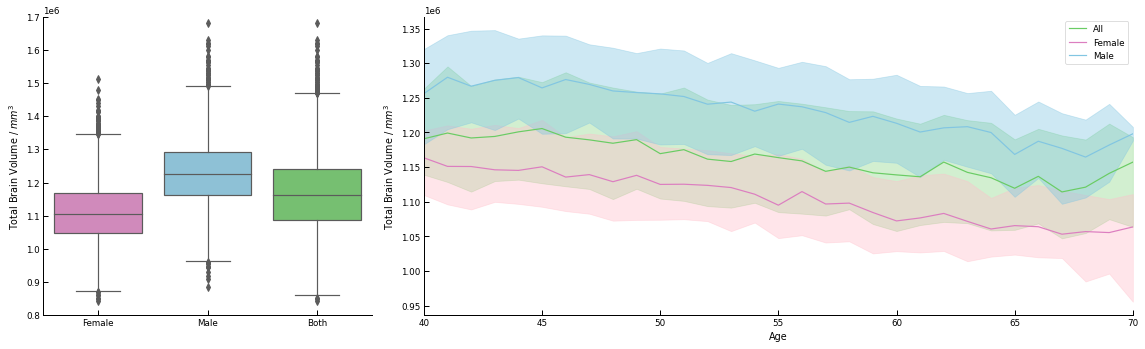

In [83]:
width = 16
height = width / (1.618 * 2)

palette = [palette_list[6], palette_list[-1], palette_list[2]]

fig = plt.figure(figsize=(width, height))
y_interval = [0.8e6, 1.7e6]
x_interval = 5

overall_corr = np.round(metadata_df['age'].corr(metadata_df['brain_volume']), 4)
print('Corr:', overall_corr)

ax1 = plt.subplot2grid((1, 3), (0, 0))
gender_vol = metadata_df[['sex', 'brain_volume']]
gender_vol_copy = metadata_df[['sex', 'brain_volume']].copy()
gender_vol_copy.sex = 2
gender_vol = pd.concat([gender_vol, gender_vol_copy])
ax = sns.boxplot(
    gender_vol.sex,
    gender_vol.brain_volume,
    ax=ax1,
    palette=palette
)
ax.set(
    xlabel=None,
    ylabel='Total Brain Volume / $mm^3$',
    xticklabels=['Female', 'Male', 'Both']
)
ax.set_ylim(y_interval)
ax.tick_params(axis='y', direction='in')
ax.tick_params(axis='x', direction='in')

def low_q(x): return np.percentile(x, 25)
def upper_q(x): return np.percentile(x, 75)
def med(x): return np.percentile(x, 50)
aggs = [low_q, med, upper_q]

ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)

overall = metadata_df.groupby('age').agg({'brain_volume': aggs})
ax2.plot(
    overall['brain_volume'].index,
    overall['brain_volume'].med,
    color=palette[2],
    label='All'
)
ax2.fill_between(
    overall['brain_volume'].index,
    overall['brain_volume'].low_q,
    overall['brain_volume'].upper_q,
    color=palette[2],
    alpha=0.3,
)

females = metadata_df[metadata_df['sex'] == 0] \
    .groupby('age') \
    .agg({'brain_volume': aggs})
ax2.plot(
    females['brain_volume'].index,
    females['brain_volume'].med,
    color=palette[0],
    label='Female'
)
ax2.fill_between(
    females['brain_volume'].index,
    females['brain_volume'].low_q,
    females['brain_volume'].upper_q,
    color='pink',
    alpha=0.4,
)

males = metadata_df[metadata_df['sex'] == 1] \
    .groupby('age') \
    .agg({'brain_volume': aggs})
ax2.plot(
    males['brain_volume'].index,
    males['brain_volume'].med,
    color=palette[1],
    label='Male'
)
ax2.fill_between(
    males['brain_volume'].index,
    males['brain_volume'].low_q,
    males['brain_volume'].upper_q,
    color=palette[1],
    alpha=0.4,
)

ax2.set(xlabel='Age', ylabel='Total Brain Volume / $mm^3$')
ax2.set_xlim([40, 70])
ax2.legend(loc='best')
ax2.tick_params(axis='y', direction='in')
ax2.tick_params(axis='x', direction='in')

sns.despine()

fig.tight_layout()
plt.savefig('age_sex_total_volume.png', dpi=300)
plt.show()

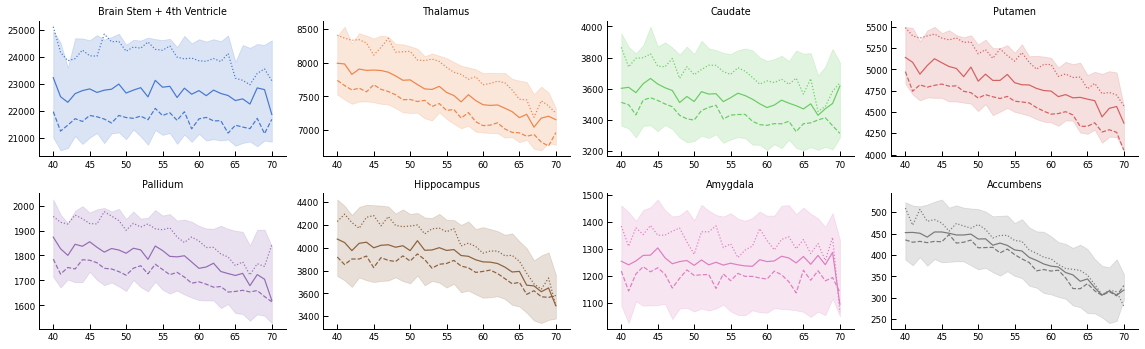

In [102]:
rename_cols = {
    '25025-2.0': 'Brain Stem + 4th Ventricle',
    '25012-2.0': 'Thalamus',
    '25014-2.0': 'Caudate',
    '25016-2.0': 'Putamen',
    '25018-2.0': 'Pallidum',
    '25020-2.0': 'Hippocampus',
    '25022-2.0': 'Amygdala',
    '25024-2.0': 'Accumbens',
    '21003-0.0': 'age',
    '31-0.0': 'sex',
}

agg_by_age_df = metadata_df_full[list(rename_cols.keys())]
agg_by_age_df.rename(columns=rename_cols, inplace=True)

width = 16
height = width / (1.618 * 2)

fig, ax = plt.subplots(
    nrows=2,
    ncols=(len(rename_cols.values()) - 1) // 2,
    figsize=(width, height),
)
# fig.text(0.5, 0.01, 'Age', ha='center', va='center')
# fig.text(0.0, 0.5, 'Subcortial Volume / $mm^3$', ha='center', va='center', rotation='vertical')
ax = ax.flatten()

for i, col in enumerate(list(rename_cols.values())):
    if col != 'age' and col != 'sex':
        agg_df = agg_by_age_df[['age', col]] \
            .groupby('age') \
            .agg({col: aggs})
        sns.lineplot(
            agg_df[col].index, agg_df[col].med,
            ax=ax[i],
            ci=None,
            color=palette_list[i],
        )
        ax[i].fill_between(
            agg_df[col].index,
            agg_df[col].low_q,
            agg_df[col].upper_q,
            color=palette_list[i],
            alpha=0.2,
        )
            
        # Groupby (sex, age), then plot dotted and dashed lines on each
        agg_by_age_sex_df = agg_by_age_df[['age', 'sex', col]] \
            .groupby(['sex', 'age']) \
            .agg({col: np.median})
        sns.lineplot(
            agg_by_age_sex_df[col][0].index,
            agg_by_age_sex_df[col][0].values,
            ax=ax[i],
            ci=None,
            color=palette_list[i],
        )
        ax[i].lines[-1].set_linestyle('--')
        sns.lineplot(
            agg_by_age_sex_df[col][1].index,
            agg_by_age_sex_df[col][1].values,
            ax=ax[i],
            ci=None,
            color=palette_list[i],
        )
        ax[i].lines[-1].set_linestyle('dotted')

        corr = np.round(agg_by_age_df['age'].corr(agg_by_age_df[col]), 4)
        ax[i].set_title(f'{col}')  #  |  r: {corr}')
        ax[i].set(ylabel=None, xlabel=None)
        ax[i].tick_params(axis='y', direction='in')
        ax[i].tick_params(axis='x', direction='in')
        ax[i].set_xlim([38, 72])
        
sns.despine()

fig.tight_layout()
plt.savefig('age_sex_subcortical_volumes.png', dpi=300)
plt.show()

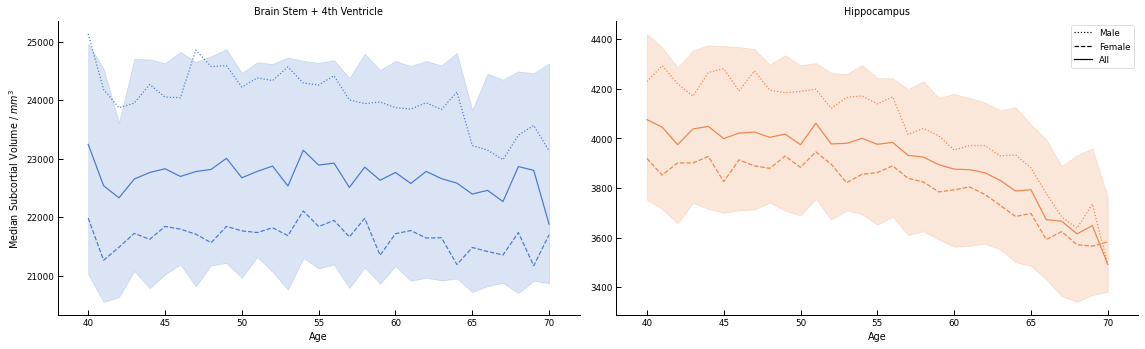

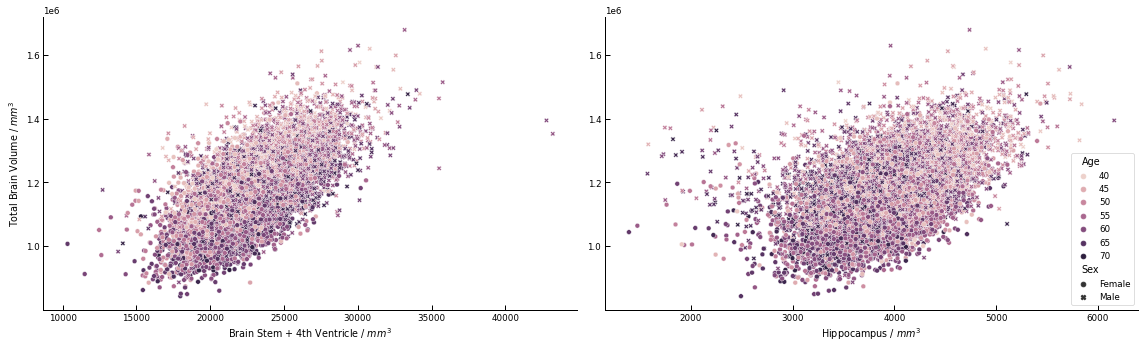

In [94]:
rename_cols = {
    '25025-2.0': 'Brain Stem + 4th Ventricle',
    '25020-2.0': 'Hippocampus',
    '21003-0.0': 'age',
    '31-0.0': 'sex',
}

agg_by_age_df = metadata_df_full[list(rename_cols.keys())]
agg_by_age_df.rename(columns=rename_cols, inplace=True)

width = 16
height = width / (1.618 * 2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(width, height))
# fig.text(0.5, 0.0, 'Age', ha='center', va='center')
# fig.text(0.0, 0.5, 'Median Subcortial Volume / $mm^3$', ha='center', va='center', rotation='vertical')
ax = ax.flatten()

for i, col in enumerate(list(rename_cols.values())):
    if col != 'age' and col != 'sex':
        agg_df = agg_by_age_df[['age', col]] \
            .groupby('age') \
            .agg({col: aggs})
        sns.lineplot(
            agg_df[col].index, agg_df[col].med,
            ax=ax[i],
            ci=None,
            color=palette_list[i],
        )
        ax[i].fill_between(
            agg_df[col].index,
            agg_df[col].low_q,
            agg_df[col].upper_q,
            color=palette_list[i],
            alpha=0.2,
        )
            
        # Groupby (sex, age), then plot dotted and dashed lines on each
        agg_by_age_sex_df = agg_by_age_df[['age', 'sex', col]] \
            .groupby(['sex', 'age']) \
            .agg({col: np.median})
        sns.lineplot(
            agg_by_age_sex_df[col][0].index,
            agg_by_age_sex_df[col][0].values,
            ax=ax[i],
            ci=None,
            color=palette_list[i],
        )
        ax[i].lines[-1].set_linestyle('--')
        sns.lineplot(
            agg_by_age_sex_df[col][1].index,
            agg_by_age_sex_df[col][1].values,
            ax=ax[i],
            ci=None,
            color=palette_list[i],
        )
        ax[i].lines[-1].set_linestyle('dotted')

        corr = np.round(agg_by_age_df['age'].corr(agg_by_age_df[col]), 4)
        ax[i].set_title(f'{col}')  #  |  r: {corr}')
        ax[i].set(ylabel=None, xlabel='Age')
        if i == 0:
            ax[i].set(ylabel='Median Subcortial Volume / $mm^3$')
        elif i == len(list(rename_cols.values())) - 3:
            ax[i].legend(ax[i].lines[::-1], ['Male', 'Female', 'All'])
            for handle in ax[i].get_legend().legendHandles:
                handle.set_color('black')
        ax[i].tick_params(axis='y', direction='in')
        ax[i].tick_params(axis='x', direction='in')
        ax[i].set_xlim([38, 72])
        
sns.despine()
fig.tight_layout()
plt.savefig('age_sex_subcortical_volumes_2.png', dpi=300)
plt.show()

# ---------------------------------------------------------------------

rename_cols = {
    '25025-2.0': 'Brain Stem + 4th Ventricle / $mm^3$',
    '25020-2.0': 'Hippocampus / $mm^3$',
    '21003-0.0': 'Age',
    '31-0.0': 'Sex',
    '25010-2.0': 'Total Brain Volume / $mm^3$',
}


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(width, height))

vals = list(rename_cols.values())
volumes_df = metadata_df_full[list(rename_cols.keys())]
volumes_df.rename(columns=rename_cols, inplace=True)
volumes_df.replace({'Sex': {0: 'Female', 1: 'Male'}}, inplace=True)

ax = sns.scatterplot(data=volumes_df, x=vals[0], y=vals[-1], hue=vals[2], style=vals[-2], ax=axes[0])
ax.get_legend().remove()
ax.tick_params(axis='y', direction='in')
ax.tick_params(axis='x', direction='in')
ax = sns.scatterplot(data=volumes_df, x=vals[1], y=vals[-1], hue=vals[2], style=vals[-2], ax=axes[1])
ax.set(ylabel=None)
ax.tick_params(axis='y', direction='in')
ax.tick_params(axis='x', direction='in')

sns.despine()
plt.tight_layout()
plt.savefig('total_to_subcortial_pairplot_2.png', dpi=300)
plt.show()

Analysing volumes of each brain substructure